In [1]:
import numpy as np
import casadi as ca
import yaml

from quadrotor import Quadrotor, Quadrotor2
from gates import Gates

In [2]:
quad = Quadrotor('./quad.yaml')
quad2 = Quadrotor2('./quad.yaml')
gates = Gates()

In [3]:
class WayPointOpt():
    def __init__(self, quad:Quadrotor, wp_num):
        self._quad = quad
        self._ddynamics = self._quad.ddynamics2()

        self._wp_num = wp_num
        self._N_per_wp = 20 # opt param
        self._Herizon = self._wp_num*self._N_per_wp

        self._X_dim = self._ddynamics.size1_in(0)
        self._U_dim = self._ddynamics.size1_in(1)
        self._X_lb = self._quad._X_lb
        self._X_ub = self._quad._X_ub
        self._U_lb = self._quad._U_lb
        self._U_ub = self._quad._U_ub

        self._DTs = ca.SX.sym('DTs', self._wp_num)
        self._Xs = ca.SX.sym('Xs', self._X_dim, self._Herizon)
        self._Us = ca.SX.sym('Us', self._U_dim, self._Herizon)
        self._WPs_p = ca.SX.sym('WPs_p', 3, self._wp_num)
        self._WPs_v = ca.SX.sym('WPs_v', 3, self._wp_num)
        # self._WPs_yaw = ca.SX.sym("WPs_yaw", 2, self._wp_num)
        self._X_init = ca.SX.sym('X_init', self._X_dim)
        self._v_end = ca.SX.sym('v_end', 3)

        self._cost_Co = ca.diag([1,2,2,2]) # opt param
        self._cost_WP_p = ca.diag([1,1,1]) # opt param
        self._cost_WP_v = ca.diag([1,1,1]) # opt param
        self._cost_end_v = ca.diag([1,1,1]) # opt param

        self._opt_option = {
            'verbose': False,
            # 'ipopt.tol': 1e-5,
            # 'ipopt.acceptable_tol': 1e-8,
            'ipopt.max_iter': 10000,
            'ipopt.warm_start_init_point': 'yes',
            # 'ipopt.print_level': 0,
        }
        self._opt_t_option = {
            'verbose': False,
            # 'ipopt.tol': 1e-2,
            # 'ipopt.acceptable_tol': 1e-8,
            'ipopt.max_iter': 10000,
            'ipopt.warm_start_init_point': 'yes',
            # 'ipopt.print_level': 0
        }

        #################################################################
        self._nlp_x_x = []
        self._nlp_lbx_x = []
        self._nlp_ubx_x = []

        self._nlp_x_u = []
        self._nlp_lbx_u = []
        self._nlp_ubx_u = []

        self._nlp_x_t = []
        self._nlp_lbx_t = []
        self._nlp_ubx_t = []

        self._nlp_g_dyn = []
        self._nlp_lbg_dyn = []
        self._nlp_ubg_dyn = []

        self._nlp_g_wp_p = []
        self._nlp_lbg_wp_p = []
        self._nlp_ubg_wp_p = []

        # self._nlp_g_wp_v = []
        # self._nlp_lbg_wp_v = []
        # self._nlp_ubg_wp_v = []

        self._nlp_g_end_v = []
        self._nlp_lbg_end_v = []
        self._nlp_ubg_end_v = []

        # self._nlp_g_wp_yaw = []
        # self._nlp_lbg_wp_yaw = []
        # self._nlp_ubg_wp_yaw = []

        self._nlp_g_quat = []
        self._nlp_lbg_quat = []
        self._nlp_ubg_quat = []

        self._nlp_p_xinit = [ self._X_init ]
        self._nlp_p_dt = []
        self._nlp_p_wp_p = []
        # self._nlp_p_wp_v = []
        self._nlp_p_end_v = [ self._v_end ]

        self._nlp_obj_minco = 0
        self._nlp_obj_time = 0
        self._nlp_obj_wp_p = 0
        # self._nlp_obj_wp_v = 0
        self._nlp_obj_end_v = 0
        self._nlp_obj_quat = 0
        self._nlp_obj_dyn = 0

        ###################################################################

        for i in range(self._wp_num):
            self._nlp_x_x += [ self._Xs[:, i*self._N_per_wp] ]
            self._nlp_lbx_x += self._X_lb
            self._nlp_ubx_x += self._X_ub
            self._nlp_x_u += [ self._Us[:, i*self._N_per_wp] ]
            self._nlp_lbx_u += self._U_lb
            self._nlp_ubx_u += self._U_ub
            self._nlp_x_t += [ self._DTs[i] ]
            self._nlp_lbx_t += [0]
            self._nlp_ubx_t += [0.5]

            if i==0:
                dd_dyn = self._Xs[:,0]-self._ddynamics( self._X_init, self._Us[:,0], self._DTs[0])
                self._nlp_g_dyn += [ dd_dyn ]
                self._nlp_obj_dyn += dd_dyn.T@dd_dyn
            else:
                dd_dyn = self._Xs[:,i*self._N_per_wp]-self._ddynamics( self._Xs[:,i*self._N_per_wp-1], self._Us[:,i*self._N_per_wp], self._DTs[i])
                self._nlp_g_dyn += [ dd_dyn ]
                self._nlp_obj_dyn += dd_dyn.T@dd_dyn
            self._nlp_lbg_dyn += [ -0.0 for _ in range(self._X_dim) ]
            self._nlp_ubg_dyn += [  0.0 for _ in range(self._X_dim) ]

            self._nlp_g_wp_p += [ (self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]).T@(self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]) ]
            self._nlp_lbg_wp_p += [0]
            self._nlp_ubg_wp_p += [ 0.001 ]
            # self._nlp_g_wp_p += [ (self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]) ]
            # self._nlp_lbg_wp_p += [-0.01,-0.01,-0.01]
            # self._nlp_ubg_wp_p += [ 0.01, 0.01, 0.01]

            self._nlp_p_dt += [ self._DTs[i] ]
            self._nlp_p_wp_p += [ self._WPs_p[:,i] ]

            self._nlp_obj_minco += (self._Us[:,i*self._N_per_wp]-[-9.91,0,0,0]).T@self._cost_Co@(self._Us[:,i*self._N_per_wp]-[-9.91,0,0,0])
            self._nlp_obj_time += self._DTs[i]*self._N_per_wp
            self._nlp_obj_wp_p += (self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]).T@self._cost_WP_p@(self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i])
            
            for j in range(1, self._N_per_wp):
                self._nlp_x_x += [ self._Xs[:, i*self._N_per_wp+j] ]
                self._nlp_lbx_x += self._X_lb
                self._nlp_ubx_x += self._X_ub
                self._nlp_x_u += [ self._Us[:, i*self._N_per_wp+j] ]
                self._nlp_lbx_u += self._U_lb
                self._nlp_ubx_u += self._U_ub

                dd_dyn = self._Xs[:,i*self._N_per_wp+j]-self._ddynamics( self._Xs[:,i*self._N_per_wp+j-1], self._Us[:,i*self._N_per_wp+j], self._DTs[i])
                self._nlp_g_dyn += [ dd_dyn ]
                self._nlp_obj_dyn += dd_dyn.T@dd_dyn
                self._nlp_lbg_dyn += [ -0.0 for _ in range(self._X_dim) ]
                self._nlp_ubg_dyn += [  0.0 for _ in range(self._X_dim) ]

                self._nlp_obj_minco += (self._Us[:,i*self._N_per_wp+j]-[-9.91,0,0,0]).T@self._cost_Co@(self._Us[:,i*self._N_per_wp+j]-[-9.91,0,0,0])
        
        self._nlp_g_end_v += [ (self._Xs[3:6,self._Herizon-1]-self._v_end).T@(self._Xs[3:6,self._Herizon-1]-self._v_end) ]
        self._nlp_lbg_end_v += [ 0 ]
        self._nlp_ubg_end_v += [ 0.001 ]
        # self._nlp_g_end_v += [ (self._Xs[3:6,self._Herizon-1]-self._v_end) ]
        # self._nlp_lbg_end_v += [-0.01,-0.01,-0.01]
        # self._nlp_ubg_end_v += [ 0.01, 0.01, 0.01]
        
        self._nlp_obj_end_v += (self._Xs[3:6,self._Herizon-1]-self._v_end).T@self._cost_end_v@(self._Xs[3:6,self._Herizon-1]-self._v_end)


    def define_opt1(self):
        nlp_dect = {
            'f': self._nlp_obj_dyn + self._nlp_obj_wp_p,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p+self._nlp_p_dt)),
            # 'g': ca.vertcat(*(self._nlp_g_dyn)),
        }
        self._opt1_solver = ca.nlpsol('opt1', 'ipopt', nlp_dect, self._opt_option)
        self._xu0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon)
        for i in range(self._Herizon):
            self._xu0[i*self._X_dim+6] = 1
            self._xu0[self._Herizon*self._X_dim+i*self._U_dim] = -9.81

    def solve_opt1(self, xinit, wp_p, dts):
        p = np.zeros(self._X_dim+3*self._wp_num+self._wp_num)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        p[self._X_dim+3*self._wp_num:] = dts
        res = self._opt1_solver(
            x0=self._xu0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u),
            # lbg=(),
            # ubg=(),
            p=p
        )
        self._xu0 = res['x'].full().flatten()
        self._dt0 = dts
        self._xut0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon+self._wp_num)
        self._xut0[:(self._X_dim+self._U_dim)*self._Herizon] = self._xu0
        self._xut0[(self._X_dim+self._U_dim)*self._Herizon:] = self._dt0
        return res

    def define_opt1_t(self):
        nlp_dect = {
            'f': self._nlp_obj_time,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u+self._nlp_x_t)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p)),
            'g': ca.vertcat(*(self._nlp_g_dyn+self._nlp_g_wp_p)),
        }
        self._opt1_t_solver = ca.nlpsol('opt1_t', 'ipopt', nlp_dect, self._opt_t_option)

    def solve_opt1_t(self, xinit, wp_p):
        p = np.zeros(self._X_dim+3*self._wp_num)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        res = self._opt1_t_solver(
            x0=self._xut0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u+self._nlp_lbx_t),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u+self._nlp_ubx_t),
            lbg=(self._nlp_lbg_dyn+self._nlp_lbg_wp_p),
            ubg=(self._nlp_ubg_dyn+self._nlp_ubg_wp_p),
            p=p
        )
        self._xut0 = res['x'].full().flatten()
        return res

    def define_opt2(self):
        nlp_dect = {
            'f': self._nlp_obj_dyn + self._nlp_obj_wp_p + self._nlp_obj_end_v,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p+self._nlp_p_end_v+self._nlp_p_dt)),
            # 'g': ca.vertcat(*(self._nlp_g_dyn)),
        }
        self._opt2_solver = ca.nlpsol('opt1', 'ipopt', nlp_dect, self._opt_option)
        self._xu0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon)
        for i in range(self._Herizon):
            self._xu0[i*self._X_dim+6] = 1
            self._xu0[self._Herizon*self._X_dim+i*self._U_dim] = -9.81

    def solve_opt2(self, xinit, wp_p, end_v, dts):
        p = np.zeros(self._X_dim+3*self._wp_num+3+self._wp_num)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        p[self._X_dim+3*self._wp_num:self._X_dim+3*self._wp_num+3] = end_v
        p[-self._wp_num:] = dts
        res = self._opt2_solver(
            x0=self._xu0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u),
            # lbg=(),
            # ubg=(),
            p=p
        )
        self._xu0 = res['x'].full().flatten()
        self._dt0 = dts
        self._xut0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon+self._wp_num)
        self._xut0[:(self._X_dim+self._U_dim)*self._Herizon] = self._xu0
        self._xut0[(self._X_dim+self._U_dim)*self._Herizon:] = self._dt0
        return res

    def define_opt2_t(self):
        nlp_dect = {
            'f': self._nlp_obj_time,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u+self._nlp_x_t)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p+self._nlp_p_end_v)),
            'g': ca.vertcat(*(self._nlp_g_dyn+self._nlp_g_wp_p+self._nlp_g_end_v)),
        }
        self._opt2_t_solver = ca.nlpsol('opt1_t', 'ipopt', nlp_dect, self._opt_t_option)
        self._xut0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon+self._wp_num)

    def solve_opt2_t(self, xinit, wp_p, end_v):
        p = np.zeros(self._X_dim+3*self._wp_num+3)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        p[-3:] = end_v
        res = self._opt2_t_solver(
            x0=self._xut0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u+self._nlp_lbx_t),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u+self._nlp_ubx_t),
            lbg=(self._nlp_lbg_dyn+self._nlp_lbg_wp_p+self._nlp_lbg_end_v),
            ubg=(self._nlp_ubg_dyn+self._nlp_ubg_wp_p+self._nlp_ubg_end_v),
            p=p
        )
        self._xut0 = res['x'].full().flatten()
        return res
    


In [4]:
opt = WayPointOpt(quad, 7)
opt.define_opt1()
opt.define_opt1_t()

In [5]:
xinit = np.array([0,0,0, 0,0,0, 1,0,0,0])
wp_p = gates._g_pos.reshape(-1)
dts = np.ones(7)*0.1

In [6]:
res = opt.solve_opt1(xinit, wp_p, dts)
# res = opt.solve_opt2(xinit, wp_p, end_v)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16434

Total number of variables............................:     1960
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1120
                     variables with only upper bounds:        0
Total number of equa

In [7]:
res = opt.solve_opt1_t(xinit, wp_p)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10877
Number of nonzeros in inequality constraint Jacobian.:       21
Number of nonzeros in Lagrangian Hessian.............:     7683

Total number of variables............................:     1967
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1127
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1400
Total number of inequality constraints...............:        7
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        7
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [41]:
def linear_table(n, t, p0, p:ca.SX):
    x = []
    x += [ (p[:,0]-p0)*t+p0 ]
    for i in range(1,n):
        x += [ (p[:,i]-p[:,i-1])*(t-i) + p[:,i-1] ]
    
    y = ca.conditional(ca.floor(t), x, x[-1])
    
    return y

class LongOpt():
    def __init__(self, quad:Quadrotor2):
        self._quad = quad
        self._ddynamics = self._quad.ddynamics(0.1)
        
        self._Herizon = 5
        
        self._X_dim = self._ddynamics.size1_in(0)
        self._U_dim = self._ddynamics.size1_in(1)
        self._X_lb = self._quad._X_lb
        self._X_ub = self._quad._X_ub
        self._U_lb = self._quad._U_lb
        self._U_ub = self._quad._U_ub
        
        self._Xs = ca.SX.sym('Xs', self._X_dim, self._Herizon)
        self._Us = ca.SX.sym('Us', self._U_dim, self._Herizon)
        self._l = ca.SX.sym('l', self._Herizon)
        
        self._X_init = ca.SX.sym("X_init", self._X_dim)
        self._trj_N = 20
        self._P_p = ca.SX.sym("P_p", 3, self._trj_N+1)
        # self._P_v = ca.SX.sym("P_v", 3, self._trj_N)
        
        self._opt_option = {
            'verbose': False,
            'ipopt.tol': 1e-3,
            # 'ipopt.acceptable_tol': 1e-8,
            'ipopt.max_iter': 50,
            # 'ipopt.warm_start_init_point': 'yes',
            # 'ipopt.print_level': 0,
        }
        
        self._nlp_x_x = []
        self._nlp_lbx_x = []
        self._nlp_ubx_x = []
        
        self._nlp_x_u = []
        self._nlp_lbx_u = []
        self._nlp_ubx_u = []
        
        self._nlp_x_l = []
        self._nlp_lbx_l = []
        self._nlp_ubx_l = []

        self._nlp_g_dyn = []
        self._nlp_lbg_dyn = []
        self._nlp_ubg_dyn = []
        
        self._nlp_g_quat = []
        self._nlp_lbg_quat = []
        self._nlp_ubg_quat = []
        
        self._nlp_p_xinit = []
        self._nlp_p_Pp = []
        # self._nlp_p_Pv = []
        
        self._nlp_obj_dyn = 0
        self._nlp_obj_trjp = 0
        self._nlp_obj_l = 0
        
        self._nlp_x_x += [ self._Xs[:, 0] ]
        self._nlp_lbx_x += self._X_lb
        self._nlp_ubx_x += self._X_ub
        self._nlp_x_u += [ self._Us[:, 0] ]
        self._nlp_lbx_u += self._U_lb
        self._nlp_ubx_u += self._U_ub
        
        self._nlp_g_quat += [ self._Xs[6:10,0].T@self._Xs[6:10,0]-1 ]
        self._nlp_lbg_quat += [-0.1 ]
        self._nlp_ubg_quat += [ 0.1 ]
        
        dd_dyn = self._Xs[:,0]-self._ddynamics( self._X_init, self._Us[:,0] )
        self._nlp_g_dyn += [ dd_dyn ]
        self._nlp_obj_dyn += dd_dyn.T@dd_dyn
        self._nlp_lbg_dyn += [ -0.0 for _ in range(self._X_dim) ]
        self._nlp_ubg_dyn += [  0.0 for _ in range(self._X_dim) ]
        
        self._nlp_obj_l += self._l[0]
        trjp = linear_table(self._trj_N, self._nlp_obj_l, self._P_p[:,0], self._P_p[:,1:])
        self._nlp_obj_trjp += (self._Xs[:3,0]-trjp).T@(self._Xs[:3,0]-trjp)
        self._nlp_x_l += [self._l[0]]
        self._nlp_lbx_l += [0]
        self._nlp_ubx_l += [self._trj_N]
        
        for i in range(1,self._Herizon):
            self._nlp_x_x += [ self._Xs[:, i] ]
            self._nlp_lbx_x += self._X_lb
            self._nlp_ubx_x += self._X_ub
            self._nlp_x_u += [ self._Us[:, i] ]
            self._nlp_lbx_u += self._U_lb
            self._nlp_ubx_u += self._U_ub
            
            self._nlp_g_quat += [ self._Xs[6:10,i].T@self._Xs[6:10,i]-1 ]
            self._nlp_lbg_quat += [-0.1 ]
            self._nlp_ubg_quat += [ 0.1 ]

            dd_dyn = self._Xs[:,i]-self._ddynamics( self._Xs[:,i-1], self._Us[:,i] )
            self._nlp_g_dyn += [ dd_dyn ]
            self._nlp_obj_dyn += dd_dyn.T@dd_dyn
            self._nlp_lbg_dyn += [ -0.0 for _ in range(self._X_dim) ]
            self._nlp_ubg_dyn += [  0.0 for _ in range(self._X_dim) ]
            
            self._nlp_obj_l += self._l[i]
            trjp = linear_table(self._trj_N, self._nlp_obj_l, self._P_p[:,0], self._P_p[:,1:])
            self._nlp_obj_trjp += (self._Xs[:3,i]-trjp).T@(self._Xs[:3,i]-trjp)
            self._nlp_x_l += [self._l[i]]
            self._nlp_lbx_l += [0]
            self._nlp_ubx_l += [self._trj_N]
        
        self._nlp_p_xinit += [self._X_init]
        
        for i in range(self._trj_N+1):
            self._nlp_p_Pp += [self._P_p[:,i]]
            # self._nlp_p_Pv += [self._P_v[:,i]]
    
    def reset_xul(self):
        self._xul0 = np.zeros((self._X_dim+self._U_dim+1)*self._Herizon)
        self._xul0[-5]=0
        self._xul0[-4]=self._xul0[-5]+1
        self._xul0[-3]=self._xul0[-4]+1
        self._xul0[-2]=self._xul0[-3]+1
        self._xul0[-1]=self._xul0[-2]+1
        # self._xul0[-1] = 8
        for i in range(self._Herizon):
            self._xul0[i*self._X_dim+6] = 1
       
    def define_opt(self):
        nlp_dect = {
            'f': -1*self._nlp_obj_l+100*(self._nlp_obj_trjp),
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u+self._nlp_x_l)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_Pp)),
            'g': ca.vertcat(*(self._nlp_g_dyn)),
        }
        self._opt_solver = ca.nlpsol('opt', 'ipopt', nlp_dect, self._opt_option)
        
        self.reset_xul()
        
    
    def solve(self, xinit, Pp, Pv):
        p = np.zeros(self._X_dim+3*(self._trj_N+1))
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*(self._trj_N+1)] = Pp
        # p[self._X_dim+3*self._trj_N:self._X_dim+3*self._trj_N+3*self._trj_N] = Pv
        res = self._opt_solver(
            x0=self._xul0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u+self._nlp_lbx_l),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u+self._nlp_ubx_l),
            lbg=(self._nlp_lbg_dyn),
            ubg=(self._nlp_ubg_dyn),
            p=p
        )
        
        self._xul0 = res['x'].full().flatten()
        
        return res

In [42]:
lopt = LongOpt(quad2)
lopt.define_opt()

In [34]:
x = res['x'].full().flatten()

us = np.zeros([4,opt._Herizon])
xs = np.zeros([10, opt._Herizon])

for i in range(opt._Herizon):
    us[:,i] = x[opt._Herizon*opt._X_dim+i*opt._U_dim:opt._Herizon*opt._X_dim+(i+1)*opt._U_dim]
    xs[:,i] = x[i*opt._X_dim:(i+1)*opt._X_dim]


In [11]:
import matplotlib.pyplot as plt

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      725
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      481

Total number of variables............................:       90
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       65
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

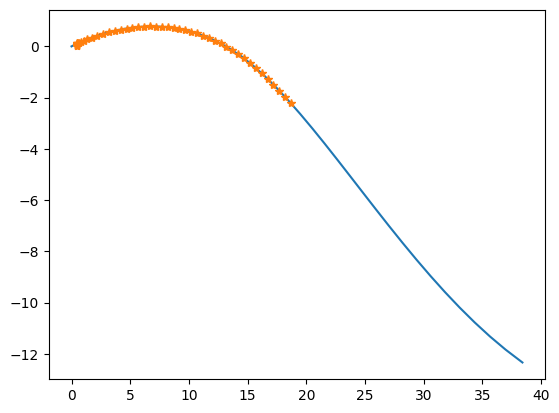

In [43]:
LL = 20
# xinit = np.array([0,0,0, 0,0,0, 1,0,0,0, 0,0,0])
xinit = np.array([0.5,0,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([0.5,0.5,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([0,0.5,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([-0.5,0.5,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([-0.5,0,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([-0.5,-0.5,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([0,-0.5,0, 0,0,0, 1,0,0,0, 0,0,0])
# xinit = np.array([0.5,-0.5,0, 0,0,0, 1,0,0,0, 0,0,0])

lopt.reset_xul()
trj = np.zeros((2,500))
T1234 = np.zeros((4,500))
Wxyz = np.zeros((3,500))

lptr = 0

Pp = np.zeros(3*(lopt._trj_N+1))
Pv = np.zeros(3*(lopt._trj_N+1))
for i in range(lopt._trj_N+1):
    Pp[3*i:3*(i+1)] = xs[:3,i]
    Pv[3*i:3*(i+1)] = xs[3:6,i]

cnt = 0
for i in range(500):
    lres = lopt.solve(xinit, Pp, Pv)
    print(lres['x'])
    xinit = lres['x'].full().flatten()[lopt._X_dim*0:lopt._X_dim*1]
    Wxyz[:,cnt] = xinit[10:13]
    T1234[:,cnt] = lres['x'].full().flatten()[lopt._X_dim*lopt._Herizon: lopt._X_dim*lopt._Herizon+lopt._U_dim]
    trj[:,cnt] = xinit[:2]
    
    tt = lres['x'].full().flatten()[-lopt._Herizon]
    if tt>2:
        lptr += int(tt-2)
        for i in range(lopt._trj_N+1):
            Pp[3*i:3*(i+1)] = xs[:3, lptr+i]
            Pv[3*i:3*(i+1)] = xs[3:6, lptr+i]
    cnt += 1
    if lptr>LL:
        break
    # lopt.reset_xul()
plt.plot(xs[0,:LL+lopt._trj_N+1], xs[1,:LL+lopt._trj_N+1])
plt.plot(trj[0,:cnt], trj[1,:cnt], '*')
# (lres['f'].full().flatten()+lres['x'].full().flatten()[-1])/1000000

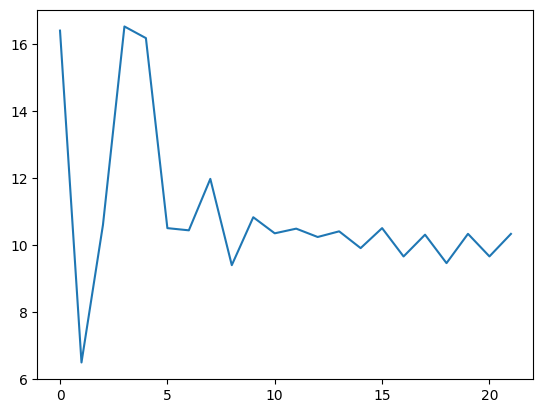

In [13]:
# plt.plot(T1234[0,:cnt])
# plt.plot(T1234[1,:cnt])
# plt.plot(T1234[2,:cnt])
# plt.plot(T1234[3,:cnt])

plt.plot(np.sum(T1234, axis=0)[:cnt])

# plt.plot(Wxyz[0,:cnt])
# plt.plot(Wxyz[1,:cnt])
# plt.plot(Wxyz[2,:cnt])

In [44]:
lopt._opt_solver.generate_dependencies("lopt.c")

'lopt.c'